#Demo for time-series load_dataset functions
ts_load_dataset_demo.ipynb

This is a brief demo and simple test of the load_dataset functions that convert the raw datasets into useable ndarrays. 
* Gets the numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D-CNN classifier for the selected dataset
* Displays model evaluation metrics and a confusion matrix

Comments:  MobiAct and UniMiB SHAR accuracies exceed 90% using total acceleration, UCI HAR and e4_Nov2019 have difficulty with standing/laying/sitting so component acceleration is included which increases overall accruacies.   This may not generalize well if the training set does not include a case where the device orientation is similar to the test case.  i.e. using component accel introduces orientation "awareness" and may hurt generalization.
The e4 data set is very small making it easy to experiment with but the loss curves will not be nearly as uniform and it is easy to overfit the data. 

Important Note: This uses the test sets - if you are still tuning your model be very careful not to inadvertently incorporate knowledge of the test set in your experiments.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* This version is work-in-progress to run without drive mount on public repo, TWristAR and Gesture-Phase-Signing have been tested.
* Make a run-all option or ability to select more than one dataset.
* Refactor the model and training to support more than one model.

#Imports

In [1]:
import os
import shutil
import urllib.request # to get files from web w/o !wget
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves

# to measure and display training time
import time
from datetime import timedelta

# model library and functions
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping

# for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')

In [3]:
import load_data_utils as utils
print(utils.get_env_info())

model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU: name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 525.85.12, 16384 MiB



In [4]:
#@title Select Dataset
dataset = "Leotta_2021" #@param ["MobiAct HAR", "UniMiB SHAR","UCI HAR","TWristAR","Leotta_2021","SHL","Gesture Phase Segmentation"]

print("Using",dataset,"dataset")
if (dataset == 'Leotta_2021'):
    print ("NOTE: this dataset requires a manual upload of the zip file")

Using Leotta_2021 dataset
NOTE: this dataset requires a manual upload of the zip file


#Get numpy arrays from load_dataset

In [5]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
if (dataset == 'MobiAct HAR'):
    !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
    # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
    # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
    get_py_file(fname = 'mobiact_adl_load_dataset.py', 
            url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
    from mobiact_adl_load_dataset import mobiact_adl_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
    k_size = 50
    EPOCHS = 50
    t_names = ['JOG','JUM','STD','STN','STU','WAL']
elif (dataset == 'UniMiB SHAR'):
    get_py_file(fname = 'unimib_adl_load_dataset.py', 
            url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
    from unimib_adl_load_dataset import unimib_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
    t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
    k_size = 50
    EPOCHS = 60
elif (dataset == 'UCI HAR'):
    get_py_file(fname = 'uci_har_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
    from uci_har_load_dataset import uci_har_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    k_size = 50
    EPOCHS = 120
elif (dataset == 'TWristAR'):
    # Note TWristAR is more updated than the previous datasets so the accesses
    # and defaults are a bit different, e.g. t_names is pulled from the .py
    get_py_file(fname = 'twristar_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
    import twristar_load_dataset as twristar_load_dataset # diff to get label map
    x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = twristar_load_dataset.twristar_load_dataset(
                                 incl_val_group = True,
                                 one_hot_encode = True)
    t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
    t_names.remove('Undefined')
    k_size = 16
    EPOCHS = 100
elif (dataset == 'Leotta_2021'):
    !gdown "1P5PIYeYvbfL4kQj-P2sm-JquUIddAxec&confirm=t" # ADL_Leotta_2021.zip
    get_py_file(fname = 'leotta_2021_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
    #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
    #shutil.copy(full_filename,'leotta_2021_load_dataset.py')
    import leotta_2021_load_dataset as leotta_2021_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True, one_hot_encode = True)
    t_names = list(leotta_2021_load_dataset.label_map_leotta.get('label').keys())
    k_size = 100
    EPOCHS = 50
elif (dataset == 'SHL'):
    # SHL takes about 30 minutes to process due to size, using saved arrays for now
    !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
    utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
    input_dir = './SHL'
    x_train = np.load(input_dir + '/'+'x_train.npy')
    x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
    x_test = np.load(input_dir + '/'+'x_test.npy')
    x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
    y_train = np.load(input_dir + '/'+'y_train.npy')
    y_test = np.load(input_dir + '/'+'y_test.npy')
    # also don't have validate working in SHL so just using stratify
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

    t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
    k_size = 15
    EPOCHS = 100
elif (dataset == 'Gesture Phase Segmentation'):
    get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
    from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = gesture_phase_segmentation_load_dataset(
                                 incl_val_group = True,
                                 return_info_dict = True)
    print("Note: Due to the size of the Gesture Phase Segmentation and for",
          "\ncompatibility, the test arrays are copies of the valid arrays")
    x_test = x_valid.copy()
    y_test = y_valid.copy()
    t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
    k_size = 9
else:
    print('ERROR: dataset unknown')
print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                   'x_valid':x_valid,'y_valid':y_valid,
                                   'x_test':x_test,'y_test':y_test}))    

Downloading...
From: https://drive.google.com/uc?id=1P5PIYeYvbfL4kQj-P2sm-JquUIddAxec&confirm=t
To: /content/ADL_Leotta_2021.zip
100% 258M/258M [00:02<00:00, 105MB/s]
Unzipping Leotta 2021 dataset into ./dataset
Using source file ./ADL_Leotta_2021.zip
array    shape           data type
-------  --------------  -----------
x_train  (2391, 300, 3)  float32
y_train  (2391, 18)      uint8
x_valid  (1167, 300, 3)  float32
y_valid  (1167, 18)      uint8
x_test   (1987, 300, 3)  float32
y_test   (1987, 18)      uint8


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#Build a 1D CNN model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [10]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
def build_1D_CNN():
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
      layers.Dropout(0.5),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(n_outputs, activation='softmax')
        ])
  return model 
model = build_1D_CNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 201, 100)          30100     
                                                                 
 conv1d_3 (Conv1D)           (None, 102, 100)          1000100   
                                                                 
 dropout_1 (Dropout)         (None, 102, 100)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 51, 100)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5100)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               510100    
                                                      

#Train the model

In [11]:
def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history
start_time = time.time()
history = train_1D_CNN(model)
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')

Epoch 1/100
75/75 [==============================] - 2s 10ms/step - loss: 2.0912 - accuracy: 0.2953 - val_loss: 1.6557 - val_accuracy: 0.3745
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 1.1650 - accuracy: 0.5713 - val_loss: 1.4089 - val_accuracy: 0.4344
Epoch 3/100
75/75 [==============================] - 1s 7ms/step - loss: 0.8082 - accuracy: 0.6993 - val_loss: 1.3306 - val_accuracy: 0.4876
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.6546 - accuracy: 0.7512 - val_loss: 1.1500 - val_accuracy: 0.5673
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.5174 - accuracy: 0.7959 - val_loss: 1.0973 - val_accuracy: 0.5844
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4671 - accuracy: 0.8227 - val_loss: 1.1192 - val_accuracy: 0.5638
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4358 - accuracy: 0.8344 - val_loss: 1.0626 - val_accuracy: 0.6058
Epoch 8/100


#Show Final Validation Accuracy and Loss Curve 

Leotta_2021 1D CNN Final Validation Accuracy: 0.573


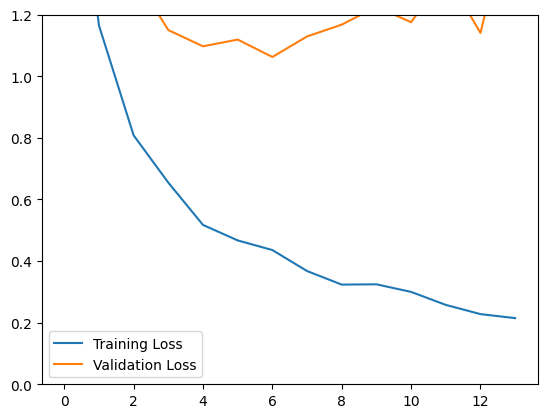

In [12]:
print(dataset, "1D CNN ", end = '')
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0,1.2]) #for consistency - 1.2 has been a good value experimentally
plt.legend()
plt.show()

# Run the model - predict using the test data

1D CNN using Leotta_2021 - Prediction Accuracy: 0.347
                  precision    recall  f1-score   support

           OTHER       0.00      0.00      0.00       777
           RELAX       0.00      0.00      0.00        80
KEYBOARD_WRITING       0.38      1.00      0.55        80
          LAPTOP       0.20      0.40      0.27        80
     HANDWRITING       0.54      0.70      0.61        80
     HANDWASHING       0.57      0.38      0.45        80
     FACEWASHING       0.28      0.54      0.37        80
      TEETHBRUSH       0.38      0.62      0.47        80
        SWEEPING       0.36      0.61      0.45        80
       VACUUMING       0.23      0.57      0.33        80
          EATING       0.20      0.29      0.23        80
         DUSTING       0.64      0.94      0.76        80
         RUBBING       0.82      0.66      0.73        80
      DOWNSTAIRS       0.35      0.59      0.44        41
         WALKING       0.31      0.97      0.47        78
    WALKING_FAST 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


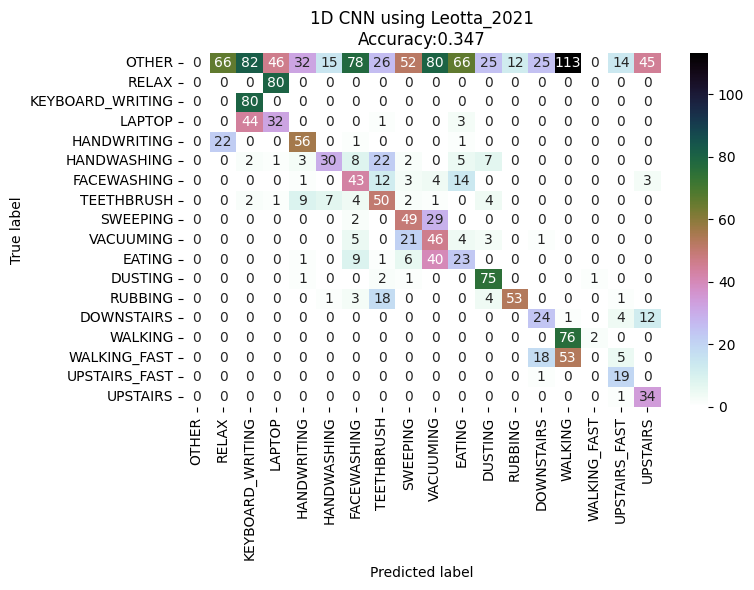

In [13]:
predictions = model.predict(x_test, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
print("1D CNN using " + dataset + ' - Prediction Accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
#return (accuracy_score(y_temp, y_pred)),y_pred
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
print(classification_report(y_test_act, y_pred, target_names=t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(8,6)) # num classes => size
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()